# US Foods COVID Analysis

Goal: 
1. Process US Foods data (source = https://usfoods.precima.io/)
2. Analyze data using COVID segmentation
3. Compare sell-out (US Foods) to sell-in (McCain) data

### 1. Load libraries, initiate folder/file paths
Run cell below

In [2]:
import pandas as pd
import datetime
from datetime import datetime as dt
import numpy as np
#import teradatasql

from distributor_transformation import transform_usfoods
from sellout_model import process_list, analyze, add_time
#from sellout_teradata import teradata_sales
from sellout_import import import_usfoods, all_df
from sellout_azure import azure_sellin

ModuleNotFoundError: No module named 'teradatasql'

### 3. Import File
Run cell below

In [2]:
file_path = r'C:\Users\newatter\OneDrive - McCain Foods Limited\Historical Sell-Out Sales\\'
file_name = 'US Foods Update.csv'

df = import_usfoods(file_path + file_name)

Importing csv file 2024-01-25 11:41:43.624044
Import file shape: (76223, 23)


In [4]:
df_usfoods = transform_usfoods(df, 'US Foods - US.xlsx')

Shape before adding dictionary: (76223, 23)
Total before dictionary: 44853577.49
Total after dictionary: 44853577.49
Shape after adding dictionary: (76223, 37)
Nothing missing for COVID Segmentation - L1
Nothing missing for products


In [5]:
backup_path = r'C:\Users\newatter\OneDrive - McCain Foods Limited\Historical Sell-Out Sales\Backups\\'

_base = all_df(df_usfoods, backup_path, 'US FOODS.csv')

Imported shape...(76223, 37)
Final shape...(2002089, 13)


In [6]:
_list = []

#Output 1: COVID L1 - List 0
_list.append(['City', 'State Name','COVID Segmentation - L1','COVID Segmentation - L2','Restaurant Service Type','Consolidated Category'])

#Output 2: COVID L1 - List 1
_list.append(['State Name','COVID Segmentation - L1','COVID Segmentation - L2','Restaurant Service Type','SKU ID','Consolidated Category','L1 Product Hierarchy','L2 Product Hierarchy'])

print(f'Processing Region', flush = True)
output1 = %time process_list(_base, _list[0], 'US Foods')


Processing Region
CPU times: total: 11.3 s
Wall time: 11.3 s


In [7]:
print(f'Processing Sell in vs Sell out', flush = True)
output2 = azure_sellin(_base, 'US01', "','".join(['6500002818']), 'US Foods')

print('All done')

Processing Sell in vs Sell out
Query ran for 6500002818 under sales org US01 for sales on or before 2024-01-21
All done, took 11.0 seconds...
All done


In [8]:
output1.to_csv('files/sellout_region_us_foods.zip', compression='zip', index=False)
output2.to_csv('files/sellout_sellin_us_foods.zip', compression='zip', index=False)

In [9]:
_base.to_csv(backup_path + 'US FOODS.csv')

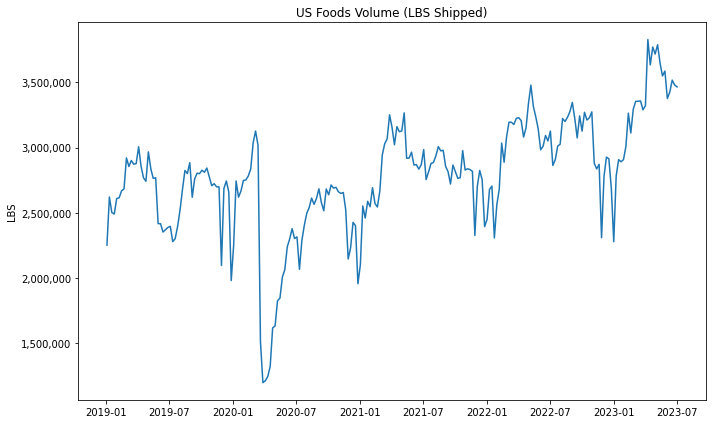

In [11]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator,
                               PercentFormatter,
                               StrMethodFormatter)

fig, ax = plt.subplots()
        
ax.plot('Week Ending (Sat)','LBS', data=output1.groupby('Week Ending (Sat)')['LBS'].sum().reset_index())
#ax.plot('month_begin','lost_freight_pred', data=data4)
#ax.plot('month_begin','shortedquantitycs', data=data4)
#ax.legend(['total_other', 'lost_freight_pred', 'Short Cases'])

ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

ax.set_ylabel('LBS')

ax.set_title(f'US Foods Volume (LBS Shipped)')

fig.set_size_inches((10, 6))

# Tight layout to realign things
fig.tight_layout()
plt.show()

In [10]:
output1.groupby('Week Ending (Sat)')['LBS'].sum().pct_change()[-6:]

Week Ending (Sat)
2023-02-25    0.051756
2023-03-04    0.019680
2023-03-11    0.001377
2023-03-18    0.001111
2023-03-25   -0.021156
2023-04-01    0.004957
Name: LBS, dtype: float64

### 9. Execute Analysis
Run cell below

In [5]:

_list = []

#Output 1: COVID L1 - List 0
_list.append(['City', 'State Name','COVID Segmentation - L1','COVID Segmentation - L2','Restaurant Service Type','Consolidated Category'])

#Output 2: COVID L1 - List 1
_list.append(['State Name','COVID Segmentation - L1','COVID Segmentation - L2','Restaurant Service Type','SKU ID','Consolidated Category','L1 Product Hierarchy','L2 Product Hierarchy'])

#Output 4: Pyramid Segment - List 2
#_list.append(['Pyramid Segment','Consolidated Category'])

print(f'Processing Region', flush = True)
output1 = process_list(_base, _list[0], 'US Foods')

#print(f'Processing Region SKU', flush = True)
#output2 = process_list(_base, _list[1])

#print(f'Processing Pyramid', flush = True)
#output4 = process_list(_base, _list[2], 'US Foods')

print(f'Processing Sell in vs Sell out', flush = True)
output3 = teradata_sales(_base, '6500002818', 'US Foods')

print('All done')

Processing Region
Processing Sell in vs Sell out
Starting Teradata connect...
Database selected!
07/19/2022
Query: Execution started...finished. 0:00:24.572184
Query: Fetching data started...finished. 0:00:19.065563
Query: Creating DataFrame for started...finished. 0:00:00.106679
Dim: (49491, 16)
All done


### 10. Upload Analysis to Teradata
Run cell below

In [6]:
def td_upload(select_db, df, table_name):
    with teradatasql.connect(None, 
                         host='172.29.3.43',
                         user='PNWATTERS',
                         password='teradata123') as con:
        with con.cursor() as cur:
            cur.execute (select_db)
            d = dt.now().strftime('%m/%d/%Y %H:%M:%S %p')
            print(f'Database selected! {d}', flush=True)           

            delete_from_td(df, table_name, cur)
            insert_into_td(df, table_name, cur)
            
def delete_from_td(df, table_name, cur):
    distributor = df.groupby('Distributor').size().reset_index().drop(columns=0).to_numpy()[0][0]
    
    print(f'Deleting records for: {distributor} in table: {table_name}', flush = True)          
    print(f'Deleting weeks: {include}', flush = True)
    
    query = '''
    DELETE FROM ''' + table_name  + ''' 
    WHERE "Distributor" = ''' + "'" + distributor + "'" + ''' AND "Calendar Week Year" IN (''' + include + ")"
    
    #query = '''
    #DELETE FROM ''' + table_name  + ''' 
    #WHERE "Distributor" = ''' + "'" + distributor + "'"
    
    cur.execute (query)
    
def insert_into_td(df, table_name, cur):
    insert_list = df.values.tolist()
    
    #creates ?, ?,.... string used in query for teradata fastload
    insert_columns = ('?, ' * len(df.columns)).rstrip(', ')
    
    print(f'Inserting records into {table_name}', flush = True)
    
    query = "INSERT INTO " + table_name  + " (" + insert_columns + ")"
    #query = "{fn teradata_try_fastload}INSERT INTO " + table_name  + " (" + insert_columns + ")"
    
    cur.execute (query, insert_list)
    
    print(f'Inserted {df.shape[0]} records', flush = True)
    

select_db = 'DATABASE DL_NA_PROTOTYPING'

exclude_list = output1['Calendar Week Year'].sort_values(ascending=False).unique().tolist()[:6]
include = str(exclude_list)[1:-1]

td_upload(select_db, output1[output1['Calendar Week Year'].isin(exclude_list)], 'SELLOUT_REGION')
#td_upload(select_db, output4[output4['Calendar Week Year'].isin(exclude_list)], 'SELLOUT_SPECIAL_1')
td_upload(select_db, output3[output3['Calendar Week Year'].isin(exclude_list)], 'SELLOUT_AND_SELLIN')

#td_upload(select_db, output2[output2['Calendar Week Year'].isin(exclude_list)].astype({'SKU ID':'str'}), 'SELLOUT_REGION_SKU')
#td_upload(select_db, output2[(output2['Calendar Week Year'] >= 201901) & (output2['Calendar Week Year'] < 202001)].astype({'SKU ID':'str'}), 'SELLOUT_REGION_SKU')

#td_upload(select_db, output1, 'SELLOUT_REGION')
#td_upload(select_db, output4, 'SELLOUT_SPECIAL_1')
#td_upload(select_db, output3, 'SELLOUT_AND_SELLIN')

print('All done', flush = True)

Database selected! 07/19/2022 16:17:27 PM
Deleting records for: US Foods in table: SELLOUT_REGION
Deleting weeks: 202228, 202227, 202226, 202225, 202224, 202223
Inserting records into SELLOUT_REGION
Inserted 3546 records
Database selected! 07/19/2022 16:17:31 PM
Deleting records for: US Foods in table: SELLOUT_AND_SELLIN
Deleting weeks: 202228, 202227, 202226, 202225, 202224, 202223
Inserting records into SELLOUT_AND_SELLIN
Inserted 24 records
All done


In [24]:
output1.columns

Index(['City', 'State Name', 'COVID Segmentation - L1',
       'COVID Segmentation - L2', 'Restaurant Service Type',
       'Consolidated Category', 'Calendar Week Year', 'Distributor', 'LBS',
       'SMA_4', 'SMA_8', 'SMA_12', 'YOY Week', 'LBS_LY', 'SMA_4_LY',
       'SMA_8_LY', 'SMA_12_LY', 'Baseline Week', 'LBS_Baseline',
       'SMA_4_Baseline', 'SMA_8_Baseline', 'SMA_12_Baseline', 'LBS_Lag_1',
       'LBS_Lag_2', 'LBS_Lag_3', 'LBS_Lag_4', 'LBS_Lag_4',
       'LBS_Baseline_Lag_1', 'LBS_LY_Lag_1', 'SMA_4_Lag_1', 'SMA_4_LY_Lag_1',
       'SMA_4_Baseline_Lag_1', 'LBS_PRECOVID', 'Week Starting (Sun)',
       'Week Ending (Sat)', 'COVID Week'],
      dtype='object')

### Save Backup When Ready

In [12]:
save_backup(_base, 'US FOODS.csv')

### Testing

In [164]:
_list = []

#Output 1: COVID L1 - List 0
_list.append(['City', 'State Name','COVID Segmentation - L1','COVID Segmentation - L2','Restaurant Service Type','Consolidated Category'])

print(f'Processing Region', flush = True)
output1 = process_list(_base, _list[0])

output1.head()

Processing Region
<class 'pandas.core.frame.DataFrame'>
Int64Index: 78574 entries, 0 to 78573
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   City                     78574 non-null  object        
 1   State Name               78574 non-null  object        
 2   COVID Segmentation - L1  78574 non-null  object        
 3   COVID Segmentation - L2  78574 non-null  object        
 4   Restaurant Service Type  78574 non-null  object        
 5   Consolidated Category    78574 non-null  object        
 6   Calendar Week Year       78574 non-null  int64         
 7   LBS                      78574 non-null  float64       
 8   LBS_LY                   78574 non-null  float64       
 9   LBS_Baseline             78574 non-null  float64       
 10  LBS_Lag_1                78574 non-null  float64       
 11  LBS_Lag_2                78574 non-null  float64       
 12  LBS_Lag_3     

None

,City,State Name,COVID Segmentation - L1,COVID Segmentation - L2,Restaurant Service Type,Consolidated Category,Calendar Week Year,Distributor,LBS,SMA_4,...,SMA_8_Baseline,SMA_12_Baseline,LBS_Lag_1,LBS_Lag_2,LBS_Lag_3,LBS_Lag_4,LBS_PRECOVID,Week Starting (Sun),Week Ending (Sat),COVID Week
0,NA,Alabama,All Other Non-Commercial,Not Applicable,Non-Restaurants,Potato,201901,US Foods,1694.6,1694.60,...,1694.60,1694.60,0.0,0.0,0.0,0.0,5027.19,2018-12-30,2019-01-05,0
1,NA,Alabama,All Other Non-Commercial,Not Applicable,Non-Restaurants,Potato,201902,US Foods,2324.1,2009.35,...,2009.35,2009.35,1694.6,0.0,0.0,0.0,5027.19,2019-01-06,2019-01-12,0
2,NA,Alabama,All Other Non-Commercial,Not Applicable,Non-Restaurants,Potato,201903,US Foods,3357.0,2458.57,...,2458.57,2458.57,2324.1,1694.6,0.0,0.0,5027.19,2019-01-13,2019-01-19,0
3,NA,Alabama,All Other Non-Commercial,Not Applicable,Non-Restaurants,Potato,201904,US Foods,9396.0,4192.92,...,4192.92,4192.92,3357.0,2324.1,1694.6,0.0,5027.19,2019-01-20,2019-01-26,0
4,NA,Alabama,All Other Non-Commercial,Not Applicable,Non-Restaurants,Potato,201905,US Foods,1737.0,4203.52,...,3701.74,3701.74,9396.0,3357.0,2324.1,1694.6,5027.19,2019-01-27,2019-02-02,0


In [59]:
test1 = _base[['City', 'State Name','COVID Segmentation - L1', 'COVID Segmentation - L2','Restaurant Service Type', 'Consolidated Category', 'Calendar Week Year','LBS']].copy()

test1_group = test1.groupby(['City', 'State Name','COVID Segmentation - L1', 'COVID Segmentation - L2','Restaurant Service Type', 'Consolidated Category', 'Calendar Week Year'])['LBS'].sum()

test1_group

City  State Name  COVID Segmentation - L1   COVID Segmentation - L2  Restaurant Service Type  Consolidated Category  Calendar Week Year
NA    Alabama     All Other Non-Commercial  Not Applicable           Non-Restaurants          Potato                 201901                1694.6
                                                                                                                     201902                2324.1
                                                                                                                     201903                3357.0
                                                                                                                     201904                9396.0
                                                                                                                     201905                1737.0
                                                                                                                                      

In [94]:
test2 = _base[['City', 'State Name','COVID Segmentation - L1', 'COVID Segmentation - L2','Restaurant Service Type', 
               'Consolidated Category', 'Calendar Week Year','LBS']].copy()

test2 = test2.merge(TIME[['Calendar Week Year','YOY Week','Baseline Week']], how = 'left', left_on = 'Calendar Week Year', right_on = 'Calendar Week Year')

test2

#test2_group = test2.groupby(['City', 'State Name','COVID Segmentation - L1', 'COVID Segmentation - L2','Restaurant Service Type', 'Consolidated Category', 'YOY Week'])['LBS'].sum()

#test2_group

,City,State Name,COVID Segmentation - L1,COVID Segmentation - L2,Restaurant Service Type,Consolidated Category,Calendar Week Year,LBS,YOY Week,Baseline Week
0,NA,North Dakota,Schools & Education,Not Applicable,Non-Restaurants,Potato,201903,24.0,201803,201903
1,NA,North Dakota,Schools & Education,Not Applicable,Non-Restaurants,Prepared Foods,201903,15.0,201803,201903
2,NA,North Dakota,Schools & Education,Not Applicable,Non-Restaurants,Potato,201903,96.0,201803,201903
3,NA,North Dakota,Schools & Education,Not Applicable,Non-Restaurants,Prepared Foods,201903,48.0,201803,201903
4,NA,North Dakota,Public Sector (On site),Not Applicable,Non-Restaurants,Potato,201903,150.0,201803,201903
...,...,...,...,...,...,...,...,...,...,...
1404265,NA,None,All Other Restaurants,National Accounts,Not Applicable,Potato,202148,11052.0,202049,201949
1404266,NA,None,All Other Restaurants,National Accounts,Not Applicable,Potato,202149,10008.0,202050,201950
1404267,NA,None,All Other Restaurants,National Accounts,Not Applicable,Potato,202150,9504.0,202051,201951
1404268,NA,None,All Other Restaurants,National Accounts,Not Applicable,Potato,202151,10512.0,202052,201952


In [111]:
def pull_yoy(row):
    print(row)
    #print(np.take(test2_group, row['Calendar Week Year']))
          
    return
          
test3 = test2_group.copy()

test3.apply(lambda x: pull_yoy(x.index))



AttributeError: 'float' object has no attribute 'index'

In [74]:
test1.index[0][-1]

201901

In [35]:
test3 = pd.concat([test1_group, test2_group], axis=1).reset_index()

test3[test3['level_6'] == 201901]

,City,State Name,COVID Segmentation - L1,COVID Segmentation - L2,Restaurant Service Type,Consolidated Category,level_6,LBS,LBS
52,NA,Alabama,All Other Non-Commercial,Not Applicable,Non-Restaurants,Potato,201901,1694.6,4806.0
262,NA,Alabama,All Other Non-Commercial,Not Applicable,Non-Restaurants,Prepared Foods,201901,291.2,254.0
472,NA,Alabama,All Other Restaurants,Independents (IOs) / Local Eateries / Takeaway,Not Applicable,Potato,201901,11213.8,34113.0
682,NA,Alabama,All Other Restaurants,Independents (IOs) / Local Eateries / Takeaway,Not Applicable,Prepared Foods,201901,1660.8,2338.0
892,NA,Alabama,All Other Restaurants,National Accounts,Not Applicable,Potato,201901,839.3,810.0
...,...,...,...,...,...,...,...,...,...
107852,NA,Wisconsin,Grocery - Convenience,Not Applicable,Non-Restaurants,Prepared Foods,201901,376.7,464.0
108062,NA,Wisconsin,Healthcare,Not Applicable,Non-Restaurants,Potato,201901,77.6,225.0
108272,NA,Wisconsin,Healthcare,Not Applicable,Non-Restaurants,Prepared Foods,201901,193.1,185.0
108482,NA,Wisconsin,Schools & Education,Not Applicable,Non-Restaurants,Potato,201901,169.8,30.0


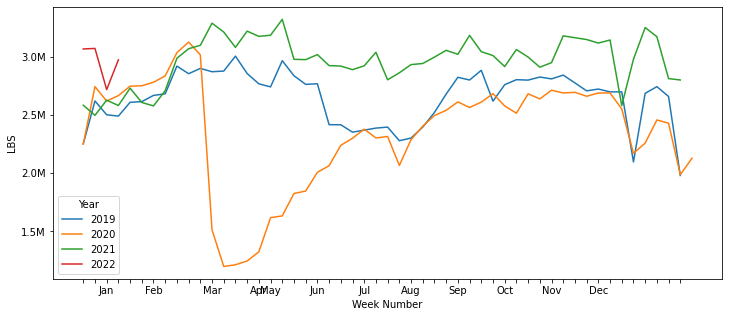

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import matplotlib.dates as mdates

df = output1.copy()
#print(df.info())

df['Week Number'] = df['Week Ending (Sat)'].dt.isocalendar().week
df['Year'] = df['Week Ending (Sat)'].dt.isocalendar().year

group = df.groupby([pd.Grouper(key='Week Ending (Sat)', freq='W'),'Distributor'])['LBS'].sum().reset_index()

group['Week Number'] = group['Week Ending (Sat)'].dt.isocalendar().week
group['Year'] = group['Week Ending (Sat)'].dt.isocalendar().year.astype('str')
#print(group['Week Number'])

fig, ax1 = plt.subplots(figsize=(12, 5))
sns.lineplot(x='Week Number', y='LBS', data=group, hue='Year', ax=ax1)

ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.1f}'.format(x/1000000) + 'M'))

#ormatter = mdates.DateFormatter("%Y-%m-%d")

#ax1.xaxis.set_major_locator(mdates.MonthLocator())
#ax1.xaxis.set_major_formatter(mdates.DateFormatter("%m"))

#ax2.xaxis.set_ticks(a) #set the ticks to be a
#ax2.xaxis.set_ticklabels(x) # change the ticks' names to x

ax1.set_xticks(range(1,53))
ax1.set_xticklabels(['','','Jan','',
                     '','','Feb','',
                     '','','','Mar',
                     '','','','Apr',
                     'May','','','',
                     'Jun','','','',
                     'Jul','','','',
                     'Aug','','','',
                     'Sep','','','',
                     'Oct','','','',
                     'Nov','','','',
                     'Dec','','','','','','',''])

plt.show()

In [37]:
group.tail()

,Week Ending (Sat),Distributor,LBS,Week Number,Year
156,2022-01-02,US Foods,2801861.09,52,2022
157,2022-01-09,US Foods,3068381.43,1,2022
158,2022-01-16,US Foods,3073082.66,2,2022
159,2022-01-23,US Foods,2719088.36,3,2022
160,2022-01-30,US Foods,2974804.93,4,2022


In [44]:
df = output1.copy()
#print(df.info())

df['Week Number'] = df['Week Ending (Sat)'].dt.isocalendar().week
#df['Year'] = df['Week Ending (Sat)'].dt.year
df['Year'] = df['Week Ending (Sat)'].dt.isocalendar().year
df

,City,State Name,COVID Segmentation - L1,COVID Segmentation - L2,Restaurant Service Type,Consolidated Category,Calendar Week Year,Distributor,LBS,SMA_4,...,LBS_Lag_1,LBS_Lag_2,LBS_Lag_3,LBS_Lag_4,LBS_PRECOVID,Week Starting (Sun),Week Ending (Sat),COVID Week,Week Number,Year
0,NA,Alabama,All Other Non-Commercial,Not Applicable,Non-Restaurants,Potato,201901,US Foods,1694.6,1694.60,...,0.0,0.0,0.0,0.0,5027.19,2018-12-30,2019-01-05,0,1,2019
1,NA,Alabama,All Other Non-Commercial,Not Applicable,Non-Restaurants,Potato,201902,US Foods,2324.1,2009.35,...,1694.6,0.0,0.0,0.0,5027.19,2019-01-06,2019-01-12,0,2,2019
2,NA,Alabama,All Other Non-Commercial,Not Applicable,Non-Restaurants,Potato,201903,US Foods,3357.0,2458.57,...,2324.1,1694.6,0.0,0.0,5027.19,2019-01-13,2019-01-19,0,3,2019
3,NA,Alabama,All Other Non-Commercial,Not Applicable,Non-Restaurants,Potato,201904,US Foods,9396.0,4192.92,...,3357.0,2324.1,1694.6,0.0,5027.19,2019-01-20,2019-01-26,0,4,2019
4,NA,Alabama,All Other Non-Commercial,Not Applicable,Non-Restaurants,Potato,201905,US Foods,1737.0,4203.52,...,9396.0,3357.0,2324.1,1694.6,5027.19,2019-01-27,2019-02-02,0,5,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94985,NA,Wisconsin,Schools & Education,Not Applicable,Non-Restaurants,Prepared Foods,202152,US Foods,70.0,70.00,...,40.0,80.0,90.0,80.0,181.52,2021-12-26,2022-01-01,94,52,2021
94986,NA,Wisconsin,Schools & Education,Not Applicable,Non-Restaurants,Prepared Foods,202201,US Foods,65.0,63.75,...,70.0,40.0,80.0,90.0,181.52,2022-01-02,2022-01-08,95,1,2022
94987,NA,Wisconsin,Schools & Education,Not Applicable,Non-Restaurants,Prepared Foods,202202,US Foods,10.0,46.25,...,65.0,70.0,40.0,80.0,181.52,2022-01-09,2022-01-15,96,2,2022
94988,NA,Wisconsin,Schools & Education,Not Applicable,Non-Restaurants,Prepared Foods,202203,US Foods,10.0,38.75,...,10.0,65.0,70.0,40.0,181.52,2022-01-16,2022-01-22,97,3,2022


# US Foods - Precima Combined File

In [38]:
import pandas as pd
import regex as re
import os

### Extracting files from SharePoint

In [85]:
#file_path = r'C:\Users\newatter\OneDrive - McCain Foods Limited\Weekly Update Files\2024-01-26\US Foods Update.csv'

def extract_usf_prima(file_path):

    # Read CSV file, only use certain columns
    df = pd.read_csv(file_path, low_memory = False, thousands = ','
                    ,usecols=['Market','Pyramid Segment','ASYS #','MFG #','Product Description','Year Week','LB Current'])

    #df['MFG #'] = df['MFG #'].astype(int).astype(str)

    return df

# Path to the directory you want to search
directory_path = r'C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Weekly Update Files'

# Create blank dataframe
us_foods = pd.DataFrame()

# Loop through each folder and file in the directory
for root, dirs, files in os.walk(directory_path):
    for file in files:
        # Check if "SharedTable_weekly_cases" is in the filename
        if "US Foods Update" in file and file.lower().endswith('.csv'):

            # Construct the full file path
            file_path = os.path.join(root, file)
            
            # Create dataframe from file
            df = extract_usf_prima(file_path)

            # Create a list of weeks in new data
            weeks_in_data = df['Year Week'].tolist()

            # If this is the first file then make dataframe same
            if us_foods.empty:  
                us_foods = df
            
            # If not first file then exclude weeks in dataframe and only keep new data
            else:
                us_foods = us_foods[~us_foods['Year Week'].isin(weeks_in_data)]
                
                us_foods = pd.concat([us_foods, df])

print(us_foods.info())


<class 'pandas.core.frame.DataFrame'>
Index: 824184 entries, 1 to 76222
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Market               824184 non-null  object 
 1   Pyramid Segment      824184 non-null  object 
 2   MFG #                824184 non-null  float64
 3   ASYS #               824184 non-null  int64  
 4   Product Description  824184 non-null  object 
 5   Year Week            824184 non-null  int64  
 6   LB Current           824184 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 50.3+ MB
None


### Add Time from Data Dictionary

In [86]:
# Path for time defintions file to convert time element to actual date (week beginning date)
file_path = r'C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Data Dictionaries\Time Definitions.xlsx'

# Only use the time worksheet in the Excel file
time_df = pd.read_excel(file_path, sheet_name='time')

#time_df.info()    

In [87]:
us_foods_with_time = us_foods.merge(time_df[['Calendar Week Year','Week Starting (Sun)']], 
                          left_on = 'Year Week',
                          right_on='Calendar Week Year')

us_foods_with_time.drop(columns={'Calendar Week Year'}, inplace=True)

us_foods_with_time.head()

,Market,Pyramid Segment,MFG #,ASYS #,Product Description,Year Week,LB Current,Week Starting (Sun)
0,BISMARCK,EDUCATION,5.075811e+13,9841260,"FRENCH TOAST, STICK CKD FZN",202103,430.0,2021-01-17
1,BISMARCK,EDUCATION,1.007271e+13,4862793,"SANDWICH, EGG BACN PTATO & CHS",202103,60.0,2021-01-17
2,BISMARCK,EDUCATION,1.007271e+13,8292377,"POTATO, MSHD PTY SMILE SKNLS",202103,48.0,2021-01-17
3,BISMARCK,GOVERNMENT,1.007271e+13,1074871,"POTATO, FF 3/8 SC BTRD BUTR",202103,150.0,2021-01-17
4,BISMARCK,GOVERNMENT,5.075811e+13,9841260,"FRENCH TOAST, STICK CKD FZN",202103,10.0,2021-01-17


### Export File as Zip

In [88]:
file_path = r'C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Sell-Out\us_foods_precima.zip'

us_foods_with_time.to_csv(file_path, index=False, compression='zip')

## Working with Old Data - Precima File

In [8]:
precima = pd.read_csv(r'C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Source Files\us_foods_precima.zip', 
                      parse_dates=['Week Starting (Sun)'])

In [15]:
rename_columns = {
    'LB Current':'LBS',
    'Week Starting (Sun)':'Week Beginning Date'
}

precima.rename(columns=rename_columns, inplace=True)

print(precima.columns)
print(precima.info())

Index(['Market', 'Pyramid Segment', 'MFG #', 'ASYS #', 'Product Description',
       'Year Week', 'LBS', 'Week Beginning Date'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 824184 entries, 0 to 824183
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Market               824184 non-null  object        
 1   Pyramid Segment      824184 non-null  object        
 2   MFG #                824184 non-null  float64       
 3   ASYS #               824184 non-null  int64         
 4   Product Description  824184 non-null  object        
 5   Year Week            824184 non-null  int64         
 6   LBS                  824184 non-null  float64       
 7   Week Beginning Date  824184 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 56.6+ MB
None


### Data Dictionary

In [16]:
# Path for time defintions file to convert time element to actual date (week beginning date)
file_path = r'C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Data Dictionaries\US Foods - US.xlsx'

segments = pd.read_excel(file_path, sheet_name='Segment Mapping v2')
regions = pd.read_excel(file_path, sheet_name='Region Mapping')
skus = pd.read_excel(file_path, sheet_name='SKU Mapping v3', dtype={'Manufacturer Item Number':'str'})

#print(segments.info())
#print(regions.info())
#print(skus.info())

In [12]:
skus

,ASYS,Manufacturer Item Number,Merch Category,PIM Group,Product,Consolidated Category,L1 Product Hierarchy,L2 Product Hierarchy,McCain SKU ID
0,5601641.0,10072714003742,COOKIES,"COOKIES, READY TO EAT, FROZEN","COOKIE, SNDWH CHOC VNL CRM",Prepared Foods,Local Portfolio,Bakery,1000004861
1,NaN,10072714006040,COOKIES,"COOKIES, READY TO EAT, FROZEN","COOKIE, SNDWH CHOC VNL CRM",Prepared Foods,Local Portfolio,Bakery,1000007909
2,NaN,10072714105224,DESSERT BARS,"BROWNIES, FROZEN","BROWNIE, DBL CHOC NOT ICED",Prepared Foods,Local Portfolio,Bakery,15010522
3,9771668.0,6007713363174,FRIED APPETIZERS,"APPETIZERS, ONIONS, BREADED & BATTERED",ONION CHIPS-MCCAIN-1000000689,Prepared Foods,Appetizer,Onion Shapes,1000000689
4,NaN,10041493107606,FRIED APPETIZERS,"APPETIZERS, ONIONS, BREADED & BATTERED","ONION RING, BTRD BEER EX THCK",Prepared Foods,Appetizer,Onion Rings,10210732
...,...,...,...,...,...,...,...,...,...
440,9040775.0,NaN,NaN,NaN,"APPETIZER, CHS MOZZ BTRD BEER",NaN,NaN,NaN,NaN
441,9071986.0,NaN,NaN,NaN,"POTATO, FF 1/2 CC FCY FZN",NaN,NaN,NaN,NaN
442,9946046.0,NaN,NaN,NaN,ONION SLIVERS BREADED FZN BAG,NaN,NaN,NaN,NaN
443,950099.0,11204530026,NaN,NaN,NaN,NaN,NaN,NaN,1120453002


In [92]:
# No longer merging for markets
precima_segments = precima.merge(segments, how='left', on='Pyramid Segment')

missing_rows = precima_segments['COVID Segmentation - L1'].isna().sum()

print(f'Missing rows = {missing_rows}')

Missing rows = 0


In [17]:
precima_regions = precima.merge(regions, how='left', on = 'Market')

missing_rows = precima_regions['Region'].isna().sum()

print(f'Missing rows = {missing_rows}')

Missing rows = 0


In [18]:
precima_skus = precima_regions.merge(skus, how='left', left_on = 'ASYS #', right_on = 'ASYS')

missing_rows = precima_skus['ASYS'].isna().sum()

print(f'Missing rows = {missing_rows}')

Missing rows = 0


### Clean ASYS column

In [19]:
precima_skus['ASYS'] = precima_skus['ASYS'].astype(int).astype(str)

print(precima_skus.columns)

Index(['Market', 'Pyramid Segment', 'MFG #', 'ASYS #', 'Product Description',
       'Year Week', 'LBS', 'Week Beginning Date', 'Region', 'Area', 'State',
       'ASYS', 'Manufacturer Item Number', 'Merch Category', 'PIM Group',
       'Product', 'Consolidated Category', 'L1 Product Hierarchy',
       'L2 Product Hierarchy', 'McCain SKU ID'],
      dtype='object')


In [96]:
columns_to_keep = ['Area', 'Region', 'Market','State','Pyramid Segment',
                   'COVID Segmentation - L1', 'COVID Segmentation - L2',
                   'COVID Segmentation - (Restaurants)','COVID Segmentation - (Restaurants: Sub-Segment)',
                   'Restaurant Service Type','ASYS','Product', 'Manufacturer Item Number',
                   'Merch Category','PIM Group','McCain SKU ID','Consolidated Category', 'L1 Product Hierarchy','L2 Product Hierarchy',
                   'Week Starting (Sun)','LBS']

file_path = r'C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Sell-Out\us_foods_precima.pkl'

precima_skus[columns_to_keep].to_pickle(file_path)

print(precima_skus[columns_to_keep].info())

#precima_skus[columns_to_keep].head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 824184 entries, 0 to 824183
Data columns (total 21 columns):
 #   Column                                           Non-Null Count   Dtype         
---  ------                                           --------------   -----         
 0   Area                                             824184 non-null  object        
 1   Region                                           824184 non-null  object        
 2   Market                                           824184 non-null  object        
 3   State                                            824184 non-null  object        
 4   Pyramid Segment                                  824184 non-null  object        
 5   COVID Segmentation - L1                          824184 non-null  object        
 6   COVID Segmentation - L2                          824184 non-null  object        
 7   COVID Segmentation - (Restaurants)               824184 non-null  object        
 8   COVID Segmentation - (Re

### US Foods - New File 

In [1]:
import pandas as pd
import regex as re
import os

In [77]:
def extract_usf_sharedtable(file_path):
    df = pd.read_csv(file_path, low_memory = False, thousands = ',')

    # Last column name = date (2024-03-24 11) with 11 being the week number of the year
    last_column = df.columns[-1]

    # Pattern to capture date in last_column
    pattern = r'(\d{4}-\d{2}-\d{2})'

    # Extract date using regex
    week_begin = re.search(pattern, last_column).group(1)

    # Change data types
    df = df.astype({
        'GTIN':'str',
        'MFG Number':'str',
        last_column: 'float'
    })

    # Rename LBS column
    df.rename(columns={last_column: 'LBS', 'Week Beginning':'Week Starting (Sun)'}, inplace=True)

    # Add week beginning column
    df['Week Starting (Sun)'] = pd.to_datetime(week_begin)

    # Drop NaN rows and realign dataframe
    df = df.dropna(subset='Market')[['Area', 'Market', 'Pyramid Segment', 'ASYS Code', 'GTIN', 'MFG Number','Week Starting (Sun)', 'LBS']]

    # Drop .0 from ASYS Code
    #df['ASYS Code'] = df['ASYS Code'].astype('int').astype('str')

    return df

# Path to the directory you want to search
directory_path = r'C:\Users\newatter\OneDrive - McCain Foods Limited\Weekly Update Files'

# Create blank dataframe
us_foods = pd.DataFrame()

# Loop through each folder and file in the directory
for root, dirs, files in os.walk(directory_path):
    for file in files:
        # Check if "SharedTable_weekly_cases" is in the filename
        if "SharedTable_weekly_cases" in file:

            # Construct the full file path
            file_path = os.path.join(root, file)
            
            df = extract_usf_sharedtable(file_path)

            us_foods = pd.concat([us_foods, df])

# Drop rows that contain '-'
rows_to_drop = us_foods[us_foods['Pyramid Segment'].str.contains('-')].index
us_foods.drop(rows_to_drop, inplace=True)

us_foods['ASYS Code'] = us_foods['ASYS Code'].astype(int)

print(us_foods.shape)

us_foods.head(4)


(61354, 8)


,Area,Market,Pyramid Segment,ASYS Code,GTIN,MFG Number,Week Starting (Sun),LBS
1,ANCHORAGE,ANCHORAGE-4190,HOSPITALITY,4180733,10072714802550,BCI00255,2024-01-21,60.0
2,ANCHORAGE,ANCHORAGE-4190,HOSPITALITY,6364970,10072714102346,80010234,2024-01-21,30.0
3,ANCHORAGE,ANCHORAGE-4190,INDEPENDENT RESTAURATEURS,987149,10072714036023,MCX03602,2024-01-21,102.0
4,ANCHORAGE,ANCHORAGE-4190,NATIONAL CHAINS,8332298,10072714101950,82910195,2024-01-21,408.0


In [78]:
us_foods.columns

Index(['Area', 'Market', 'Pyramid Segment', 'ASYS Code', 'GTIN', 'MFG Number',
       'Week Starting (Sun)', 'LBS'],
      dtype='object')

In [79]:
# Path for time defintions file to convert time element to actual date (week beginning date)
file_path = r'C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Data Dictionaries\US Foods - US.xlsx'

segments = pd.read_excel(file_path, sheet_name='Segment Mapping v2')
regions = pd.read_excel(file_path, sheet_name='Region Mapping v2')

skus = pd.read_excel(file_path, sheet_name='SKU Mapping v3', dtype={'Manufacturer Item Number':'str'})

skus_clean = skus[~skus['ASYS'].isna()].copy()

In [80]:
us_foods_segments = us_foods.merge(segments, how='left', on='Pyramid Segment')

missing_rows = us_foods_segments['COVID Segmentation - L1'].isna().sum()

print(f'Missing rows = {missing_rows}')

Missing rows = 0


In [81]:
us_foods_regions = us_foods_segments.merge(regions[['Market','Region','State']], how='left', on='Market')

missing_rows = us_foods_regions['State'].isna().sum()

print(f'Missing rows = {missing_rows}')

Missing rows = 0


In [99]:
skus_clean['ASYS'] = skus_clean['ASYS'].astype(int)

us_foods_skus = us_foods_regions.merge(skus_clean, how='left', left_on='ASYS Code', right_on = 'ASYS')

us_foods_skus['ASYS'] = us_foods_skus['ASYS'].astype(str)

missing_rows = us_foods_skus['ASYS'].isna().sum()

print(f'Missing rows = {missing_rows}')

Missing rows = 0


In [83]:
us_foods_skus.columns

Index(['Area', 'Market', 'Pyramid Segment', 'ASYS Code', 'GTIN', 'MFG Number',
       'Week Starting (Sun)', 'LBS', 'COVID Segmentation - L1',
       'COVID Segmentation - L2', 'COVID Segmentation - (Restaurants)',
       'COVID Segmentation - (Restaurants: Sub-Segment)',
       'Restaurant Service Type', 'Region', 'State', 'ASYS',
       'Manufacturer Item Number', 'Merch Category', 'PIM Group', 'Product',
       'Consolidated Category', 'L1 Product Hierarchy', 'L2 Product Hierarchy',
       'McCain SKU ID'],
      dtype='object')

In [100]:
columns_to_keep = ['Area', 'Region', 'Market','State','Pyramid Segment',
                   'COVID Segmentation - L1', 'COVID Segmentation - L2',
                   'COVID Segmentation - (Restaurants)','COVID Segmentation - (Restaurants: Sub-Segment)',
                   'Restaurant Service Type','ASYS', 'Product', 'Manufacturer Item Number',
                   'Merch Category','PIM Group','McCain SKU ID','Consolidated Category', 'L1 Product Hierarchy','L2 Product Hierarchy',
                   'Week Starting (Sun)','LBS']

print(us_foods_skus[columns_to_keep].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61354 entries, 0 to 61353
Data columns (total 21 columns):
 #   Column                                           Non-Null Count  Dtype         
---  ------                                           --------------  -----         
 0   Area                                             61354 non-null  object        
 1   Region                                           61354 non-null  object        
 2   Market                                           61354 non-null  object        
 3   State                                            61354 non-null  object        
 4   Pyramid Segment                                  61354 non-null  object        
 5   COVID Segmentation - L1                          61354 non-null  object        
 6   COVID Segmentation - L2                          61354 non-null  object        
 7   COVID Segmentation - (Restaurants)               61354 non-null  object        
 8   COVID Segmentation - (Restaurants: S

### Combine Precima with New Data

In [111]:
source_path = r'C:/Users/newatter/OneDrive - McCain Foods Limited/Distributor Sell-Out/Source Files/us_foods_precima.pkl'

precima = pd.read_pickle(source_path)

us_foods_all = pd.concat([us_foods_skus[columns_to_keep], precima])

file_name = 'us_foods'
pickle_path = 'C:/Users/newatter/OneDrive - McCain Foods Limited/Distributor Sell-Out/Source Files'
csv_path = 'C:/Users/newatter/OneDrive - McCain Foods Limited/Distributor Sell-Out/Sell-Out'

#us_foods_all.to_pickle(f'{pickle_path}/{file_name}.pkl')

compression_opts = dict(method='zip', archive_name=f'{file_name}.csv')

us_foods_all.to_csv(f'{csv_path}/{file_name}.zip', index=False, 
                    compression=compression_opts)

In [104]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 885538 entries, 0 to 824183
Data columns (total 21 columns):
 #   Column                                           Non-Null Count   Dtype         
---  ------                                           --------------   -----         
 0   Area                                             885538 non-null  object        
 1   Region                                           885538 non-null  object        
 2   Market                                           885538 non-null  object        
 3   State                                            885538 non-null  object        
 4   Pyramid Segment                                  885538 non-null  object        
 5   COVID Segmentation - L1                          885538 non-null  object        
 6   COVID Segmentation - L2                          885538 non-null  object        
 7   COVID Segmentation - (Restaurants)               885538 non-null  object        
 8   COVID Segmentation - (Restaur

In [ ]:
import pyodbc
import sqlalchemy
from sqlalchemy import create_engine, MetaData, Table
from sqlalchemy.engine import URL
from datetime import datetime
import pandas as pd

class us_foods_sellout:
    def __init__(self, file_path) -> None:
        self.filepath = file_path
        self.data = self.process_file()
        self.data_import = self.filter_rows()
        #self.delete_rows()
        self.insert_rows()

    def fill_in_missing_data(self):
        file_path = r'C:\Users\newatter\OneDrive - McCain Foods Limited\Distributor Sell-Out\Data Dictionaries\US Foods - US.xlsx'
        skus = pd.read_excel(file_path, sheet_name='SKU Mapping v3', dtype={'Manufacturer Item Number':'str'})

        skus_clean = skus[~skus['ASYS'].isna()].copy()
        regions = pd.read_excel(file_path, sheet_name='Region Mapping v2')
        self.data = self.data.merge(regions[['Market','Region','State']], how='left', on='Market')

        skus_clean['ASYS'] = skus_clean['ASYS'].astype(int)

        us_foods_skus = us_foods_regions.merge(skus_clean, how='left', left_on='ASYS Code', right_on = 'ASYS')

        us_foods_skus['ASYS'] = us_foods_skus['ASYS'].astype(str)

    def process_file(self):
        df = pd.read_csv(file_path, low_memory = False, thousands = ',')

        # Last column name = date (2024-03-24 11) with 11 being the week number of the year
        last_column = df.columns[-1]

        # Pattern to capture date in last_column
        pattern = r'(\d{4}-\d{2}-\d{2})'

        # Extract date using regex
        week_begin = re.search(pattern, last_column).group(1)

        # Change data types
        df = df.astype({
            'GTIN':'str',
            'MFG Number':'str',
            last_column: 'float'
        })

        rename_columns = {
            last_column: 'LBS', 
            'Week Beginning':'Week Beginning Date',
            'ASYS Code':'ASYS ID',
            'GTIN':'Manufacturer GTIN',
            'MFG Number':'McCain SKU ID'
        }
        # Rename LBS column
        df.rename(columns=rename_columns, inplace=True)

        # Add week beginning column
        df['Week Beginning Date'] = pd.to_datetime(week_begin)

        # Drop NaN rows and realign dataframe
        df = df.dropna(subset='Market')

        # Drop rows that contain '-'
        rows_to_drop = us_foods[us_foods['Pyramid Segment'].str.contains('-')].index
        us_foods.drop(rows_to_drop, inplace=True)

        df['ASYS ID'] = df['ASYS ID'].astype(int).astype()

        return df[['Area', 'Market', 'Pyramid Segment', 'ASYS Code', 'GTIN', 'MFG Number','Week Starting (Sun)', 'LBS']]
    
    def setup_connection():
        server = 'mf-enterprise-dev-sql.46ac3df1733c.database.windows.net'
        database = 'PWRAPPDB'
        driver = '{ODBC Driver 17 for SQL Server}'

        # Establish the database connection using AAD Integrated Authentication
        conn_str = (
            f'DRIVER={driver};'
            f'SERVER=tcp:{server};'
            f'DATABASE={database};'
            'Authentication=ActiveDirectoryIntegrated'
        )

        cnxn = pyodbc.connect(conn_str)
        cursor = cnxn.cursor()

        return cnxn, cursor


    def filter_rows(self):
        sql_select = """
        SELECT [Week Beginning Date] 
        FROM [na_dist].[US_USFoods_Sellout]
        GROUP BY [Week Beginning Date] """

        cnxn, cursor = us_foods_sellout.setup_connection()

        cursor.execute(sql_select)

        # Fetch the results
        results = cursor.fetchall()

        # Convert the results into a list of dates
        dates_in_db = [result[0] if result[0] is not None else None for result in results]
        dates_in_db = pd.to_datetime([date for date in dates_in_db if date is not None])

        # Commit the transactions
        cnxn.commit()

        # Close the connection
        cursor.close()
        cnxn.close()

        return self.data[~self.data['Week Beginning Date'].isin(dates_in_db)]

    def setup_miengine():
        server = 'mf-enterprise-dev-sql.46ac3df1733c.database.windows.net'
        database = 'PWRAPPDB'
        driver = '{ODBC Driver 17 for SQL Server}'

        # Establish the database connection using AAD Integrated Authentication
        conn_str = URL.create(
            'mssql+pyodbc',
            query={
                'odbc_connect':(
                    f'DRIVER={driver};'
                    f'SERVER=tcp:{server};'
                    f'DATABASE={database};'
                    'Authentication=ActiveDirectoryIntegrated;'
            )
            }
        )

        engine = create_engine(conn_str, connect_args={"autocommit": True}, fast_executemany=True, use_insertmanyvalues=False)

        return engine

        
    def insert_rows(self):
        engine = us_foods_sellout.setup_miengine()

        table_name = 'US_USFoods_Sellout'
        schema_name = 'na_dist'

        # If the table doesn't exist, it will be created automatically
        self.data_import.to_sql(table_name, con=engine, schema=schema_name, if_exists='append', index=False)


In [ ]:
file_path = r''

us_foods_sellout(file_path)

# Upload Precima data to SQL database

In [1]:
import pyodbc
import sqlalchemy
from sqlalchemy import create_engine, MetaData, Table
from sqlalchemy.engine import URL
from datetime import datetime
import pandas as pd


def setup_miengine():
        server = 'mf-enterprise-dev-sql.46ac3df1733c.database.windows.net'
        database = 'PWRAPPDB'
        driver = '{ODBC Driver 17 for SQL Server}'

        # Establish the database connection using AAD Integrated Authentication
        conn_str = URL.create(
            'mssql+pyodbc',
            query={
                'odbc_connect':(
                    f'DRIVER={driver};'
                    f'SERVER=tcp:{server};'
                    f'DATABASE={database};'
                    'Authentication=ActiveDirectoryIntegrated;'
            )
            }
        )

        # use_insertmanyvalues=False
        engine = create_engine(conn_str, 
                               connect_args={"autocommit": True}, 
                               fast_executemany=True,
                               use_insertmanyvalues=False)

        return engine

In [11]:
def insert_rows(df):
        engine = setup_miengine()

        table_name = 'US_USFoods_Sellout'
        schema_name = 'na_dist'

        # If the table doesn't exist, it will be created automatically
        df.to_sql(table_name, con=engine, schema=schema_name, if_exists='append', index=False, chunksize = None)

In [3]:
source_path = r'C:/Users/newatter/OneDrive - McCain Foods Limited/Distributor Sell-Out/Source Files/us_foods_precima.pkl'

precima = pd.read_pickle(source_path)

print(precima.columns)
print(precima.info())

Index(['Area', 'Region', 'Market', 'State', 'Pyramid Segment',
       'COVID Segmentation - L1', 'COVID Segmentation - L2',
       'COVID Segmentation - (Restaurants)',
       'COVID Segmentation - (Restaurants: Sub-Segment)',
       'Restaurant Service Type', 'ASYS', 'Product',
       'Manufacturer Item Number', 'Merch Category', 'PIM Group',
       'McCain SKU ID', 'Consolidated Category', 'L1 Product Hierarchy',
       'L2 Product Hierarchy', 'Week Starting (Sun)', 'LBS'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 824184 entries, 0 to 824183
Data columns (total 21 columns):
 #   Column                                           Non-Null Count   Dtype         
---  ------                                           --------------   -----         
 0   Area                                             824184 non-null  object        
 1   Region                                           824184 non-null  object        
 2   Market                               

In [4]:
columns_to_keep = ['Area', 'Region', 'Market', 'State', 'Pyramid Segment','ASYS', 'Product',
       'Manufacturer Item Number', 'McCain SKU ID','Week Starting (Sun)', 'LBS']

rename_columns = {
    'ASYS':'ASYS ID', 
    'Product':'ASYS Description',
    'Manufacturer Item Number':'Manufacturer GTIN',
    'Week Starting (Sun)':'Week Beginning Date'
}

usf = precima[columns_to_keep].rename(columns=rename_columns)

print(usf.columns)

Index(['Area', 'Region', 'Market', 'State', 'Pyramid Segment', 'ASYS ID',
       'ASYS Description', 'Manufacturer GTIN', 'McCain SKU ID',
       'Week Beginning Date', 'LBS'],
      dtype='object')


In [6]:
usf['Week Beginning Date'].unique()

<DatetimeArray>
['2021-01-17 00:00:00', '2021-01-24 00:00:00', '2021-01-31 00:00:00',
 '2021-02-14 00:00:00', '2021-02-07 00:00:00', '2021-02-21 00:00:00',
 '2021-02-28 00:00:00', '2021-03-07 00:00:00', '2021-03-14 00:00:00',
 '2021-03-28 00:00:00',
 ...
 '2023-12-10 00:00:00', '2024-01-14 00:00:00', '2023-11-26 00:00:00',
 '2023-12-03 00:00:00', '2023-10-29 00:00:00', '2023-11-05 00:00:00',
 '2023-11-12 00:00:00', '2023-11-19 00:00:00', '2023-12-17 00:00:00',
 '2023-12-24 00:00:00']
Length: 157, dtype: datetime64[ns]

In [21]:
def setup_connection():
        server = 'mf-enterprise-dev-sql.46ac3df1733c.database.windows.net'
        database = 'PWRAPPDB'
        driver = '{ODBC Driver 17 for SQL Server}'

        # Establish the database connection using AAD Integrated Authentication
        conn_str = (
            f'DRIVER={driver};'
            f'SERVER=tcp:{server};'
            f'DATABASE={database};'
            'Authentication=ActiveDirectoryIntegrated'
        )

        cnxn = pyodbc.connect(conn_str)
        cursor = cnxn.cursor()

        return cnxn, cursor


def filter_rows():
    sql_select = """
    SELECT [Week Beginning Date] 
    FROM [na_dist].[US_USFoods_Sellout]
    GROUP BY [Week Beginning Date] """

    cnxn, cursor = setup_connection()

    cursor.execute(sql_select)

    # Fetch the results
    results = cursor.fetchall()

    # Convert the results into a list of dates
    dates_in_db = [result[0] if result[0] is not None else None for result in results]
    dates_in_db = pd.to_datetime([date for date in dates_in_db if date is not None])

    # Commit the transactions
    cnxn.commit()

    # Close the connection
    cursor.close()
    cnxn.close()

    return dates_in_db

In [12]:
insert_rows(usf[usf['Week Beginning Date']=='2021-02-14'])

In [37]:
cnt = 0

weeks_in_db = filter_rows()

for week in usf['Week Beginning Date'].unique():
    if cnt >= 10:
        break
    if week not in weeks_in_db:
        print(week)
        insert_rows(usf[usf['Week Beginning Date']==week])
        cnt += 1
        

    
    



2023-11-19 00:00:00
2023-12-17 00:00:00
2023-12-24 00:00:00
